Numerical Exercise #3 from Light #2.

Download an optical spectrum of a luminous quasar at redshift z ~ 2.5. Identify the Lyman alpha emission line and estimate its full width half maximum in angstroms. Assuming the width is dominated by Doppler motions, what is that width in km/s? 

My approach:

Below the data used is a from a quasar ( see http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=517&mjd=52024&fiber=466) with redshift z = 2.517.

First I extract the full width half maximum of the Lyman alpha line using peak finding and peak width finding routines.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.signal import find_peaks, peak_widths

In [2]:
FILENAME  = 'spSpec-52024-0517-466.fit'


"""
The following is adapted from AstroML AstroML/tools/sdss_fits.py, 
see https://github.com/astroML/astroML/blob/main/astroML/datasets/tools/sdss_fits.py

Tools to download and process SDSS fits files.
More information can be found at
http://www.sdss.org/dr7/products/spectra/index.html

Data Structure: the following is copied from http://www.sdss.org/dr7/dm/flatFiles/spSpec.html
The first row is the spectrum, the second row is the continuum subtracted spectrum, 
the third row is the noise in the spectrum (standard deviation, in the same units as the spectrum), 
the forth row is the mask array. The spectra are binned log-linear. Units are 10^(-17) erg/cm^2/s/Ang.

SDSS spectra are binned in constant Log(Λ ) and the wavelength can be obtained from the header 
parameters COEFF0 and COEFF1 (or alternatively CRVAL1 and CD1_1) as follows:

lambda = 10^(COEFF0 + COEFF1*i), where i denotes the (zero indexed) pixel number.


Flags used in mask array:
Each pixel in the MASK array (row 4) is a bit mask, with the following legal values:
 SP_MASK_OK           =  0x000,      
 SP_MASK_NOPLUG       =  0x001,      /*  Fiber not listed in plugmap file                     */
 SP_MASK_BADTRACE     =  0x002,      /*  Bad trace from routine TRACE320CRUDE                 */
 SP_MASK_BADFLAT      =  0x004,      /*  Low counts in fiberflat                              */
 SP_MASK_BADARC       =  0x008,      /*  Bad arc solution                                     */
 SP_MASK_MANYBADCOL   =  0x010,      /*  More than 10% pixels are bad columns                 */
 SP_MASK_MANYREJECT   =  0x020,      /*  More than 10% pixels are rejected in extraction      */
 SP_MASK_LARGESHIFT   =  0x040,      /*  Large spatial shift between flat and object position */
 SP_MASK_NEARBADPIX   =  0x10000,    /*  Bad pixel within 3 pixels of trace                   */
 SP_MASK_LOWFLAT      =  0x20000,    /*  Flat field less than 0.5                             */
 SP_MASK_FULLREJECT   =  0x40000,    /*  Pixel fully rejected in extraction                   */
 SP_MASK_PARTIALREJ   =  0x80000,    /*  Some pixels rejected in extraction                   */
 SP_MASK_SCATLIGHT    =  0x100000,   /*  Scattered light significant                          */
 SP_MASK_CROSSTALK    =  0x200000,   /*  Cross-talk significant                               */
 SP_MASK_NOSKY        =  0x400000,   /*  Sky level unknown at this wavelength                 */
 SP_MASK_BRIGHTSKY    =  0x800000,   /*  Sky level > flux + 10*(flux error)                   */
 SP_MASK_NODATA       =  0x1000000,  /*  No data available in combine B-spline                */
 SP_MASK_COMBINEREJ   =  0x2000000,  /*  Rejected in combine B-spline                         */
 SP_MASK_BADFLUXFACTOR=  0x4000000,  /*  Low flux-calibration or flux-correction factor       */
 SP_MASK_BADSKYCHI    =  0x8000000,  /*  Chi^2 > 4 in sky residuals at this wavelength        */
 SP_MASK_REDMONSTER   =  0x10000000, /*  Contiguous region of bad chi^2 in sky residuals      */
 SP_MASK_EMLINE       =  0x40000000  /*  Emission line detected here  


These HDUs list the measured properties of individual emission/absorption lines in the spectrum. 
There are two HDUs of this type. The first HDU of this type (HDU 1) lists all lines found automatically 
by the wavelet filter, with no apriori knowledge of the redshift. The second HDU of this type (HDU 2) 
lists all lines measured based on their expected positions from the highest-confidence emission line redshift. 
Under most circumstances, the line measurements in HDU 2 should be used.

"""


class SDSSfits:
    """ SDSS fits files
    
    Parameters
    ----------
    FILENAME : string 
    file path to SDSS fits file
    Notes
    -----
    refer to the data description:
    http://www.sdss.org/dr7/dm/flatFiles/spSpec.html
    """

    def __init__(self, FILENAME):
        self.hdulist = fits.open(FILENAME)
        self._initialize(self.hdulist)
        
        
    def _initialize(self, hdulist):
        data = hdulist[0].data

        self.name = hdulist[0].header['NAME']
        self.spec_cln = hdulist[0].header['SPEC_CLN']
        self.coeff0 = hdulist[0].header['COEFF0']
        self.coeff1 = hdulist[0].header['COEFF1']
        self.z = hdulist[0].header['Z']
        self.zerr = hdulist[0].header['Z_ERR']
        self.zconf = hdulist[0].header['Z_CONF']

        self.spectrum = data[0] # spectrum data
        self.spectrum_cont = data[1] 
        self.error = data[2] 
        self.mask = data[3] 
        
        self.lines = hdulist[2].data

    def get_line(self, wavelength):
        """
        get the desired line's wavelength. here, the input wavelength is the desired line's vacuum wavelength
        """
        index = np.where(np.abs(self.lines['restwave']-wavelength)<1)
        xloc = self.lines['wave'][index]
        return xloc

    def wavelength(self):
        """
        return the wavelength of the spectrum in angstroms
        """
        return 10 ** (self.coeff0 + self.coeff1 * np.arange(len(self.spectrum)))
    
    def apply_mask(self):
        """
        filter out "bad" data
        """
        arr_0s = np.where(self.mask == 0)[0]
        arr_lines = np.where(self.mask == float.fromhex('0x40000000'))[0]
        goodlist = np.sort(np.hstack((arr_0s, arr_lines)))
        return goodlist
    
    def fullwidth_halfmax(self, wavelength, select = 10, cut = 500):
        """
        calculate full width half maximum in angstroms
        
        the strategy here is to select a small region around the desired line and search for peaks.
        the desired line should have the largest full width half maximum in the chosen region.
        then the full width half maximum is measured using scipy.signal.peak_widths.
        
        parameters
        -----------
        wavelength: vacuum wavelength of line at which to calculate the FWHM
        select: select wavelength bounds for the peak search region
        cut: a cutoff wavelength. plot the region between chosen line-cut and chosen line+cut
        
        returns
        ----------
        fwhm: the full width half maximum in angstroms of the chosen line
        peak: the height of the fwhm of the chosen line
        leftbound: the leftmost wavelength index of the chosen line at fwhm
        rightbound: the rightmost wavelength index of the chosen line at fwhm
        """
        x = self.spectrum_cont # the background subtracted spectrum
        line = self.get_line(wavelength) # line wavelength
        peaks, _ = find_peaks(x) # wavelength indices of peaks
        results_half = peak_widths(x, peaks, rel_height=0.5)
        wavelengths = self.wavelength()
        index = np.where(np.abs((wavelengths-line))<0.2) # find the wavelength index of the desired line
        index2 = np.where(np.abs(peaks-index)<1.5)[1] # find the peak index of the desired line
        index3 = np.argsort(results_half[0][index2[0]-select:index2[0]+select])[::-1][0] # peak widths, ranked
        fig, ax = plt.subplots()
        plt.plot(x[index[0][0]-cut:index[0][0]+cut]) # plot the results
        plt.vlines(index, -20, 100, color = 'r')
        
        height = results_half[1][index2[0]-select:index2[0]+select][index3] # height of peak at fwhm
        leftbound = (results_half[2][index2[0]-select:index2[0]+select][index3]).astype('int') # left fwhm bound
        rightbound = (results_half[3][index2[0]-select:index2[0]+select][index3]).astype('int') # right fwhm bound
        fwhm = wavelengths[rightbound]-wavelengths[leftbound]
        
        plt.hlines(height, \
                   leftbound,\
                   rightbound, color="C2")
        
        plt.xlabel('sample #')
        plt.ylabel('10^(-17) erg/cm^2/s/Ang')
        return fwhm, height, leftbound, rightbound
    
    def close(self):
        self.hdulist.close()

In [3]:
SDSSobj = SDSSfits(FILENAME)

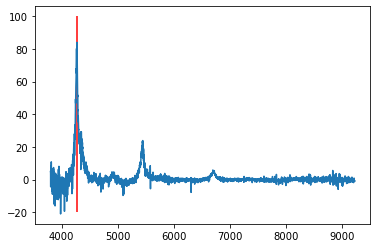

In [4]:
WAVELENGTH = 1215.67
line = SDSSobj.get_line(WAVELENGTH)
wavelengths = SDSSobj.wavelength()
spectrum = SDSSobj.spectrum_cont
plt.plot(wavelengths,spectrum)
plt.vlines(line, -20,100, color = 'r')

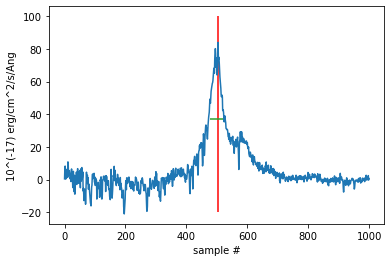

In [5]:
fwhm, height, leftbound, rightbound = SDSSobj.fullwidth_halfmax(WAVELENGTH)
SDSSobj.close()

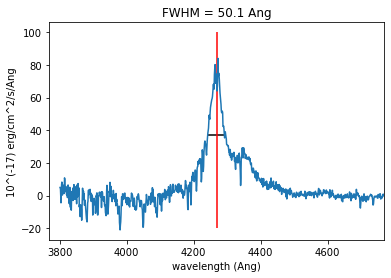

In [6]:
fig, ax = plt.subplots()
plt.plot(wavelengths, spectrum)
plt.hlines(height, wavelengths[leftbound],wavelengths[rightbound],color="black")
plt.vlines(line, -20, 100, color = 'r')
plt.xlim(line-500, line+500)
plt.xlabel('wavelength (Ang)')
plt.ylabel('10^(-17) erg/cm^2/s/Ang')
plt.title(f'FWHM = {np.around(fwhm,2)} Ang')
plt.show()

### Calculating the quasar speed with respect to the observer

We now have the full width half maximum of the Lyman alpha line in angstroms. Now we want to find what range of quasar speeds (with respect to the observer) that width corresponds to. The spectral lines of the quasar's spectrum have width because the quasar is moving with respect to us, therefore redshifting/blueshifting its spectrum depending on what rotation the quasar is doing with respect to us. 

So the width of the quasar's spectral lines can tell us the change in frequency due to its motion with respect to the observer. Using the doppler effect, we can turn that frequency shift into a relative velocity for the quasar.

So use $\Delta f={\frac {\Delta v}{c}}f_{0}$ and find the relative velocity $\Delta v$.

In [7]:
min_wavelength = wavelengths[leftbound]
max_wavelength = wavelengths[rightbound]
c = 3*10**8
max_freq = c/(max_wavelength*10**-10) #1/s
min_freq = c/(min_wavelength*10**-10) #1/2
f0 = c/(line[0]*10**-10)
deltaf_max = max_freq - f0
deltav_max = c*deltaf_max/f0
deltaf_min = min_freq - f0
deltav_min = c*deltaf_min/f0

In [8]:
deltav_max*10**-3

-1581.3237582612937

In [9]:
deltav_min*10**-3

1943.7187603937446

In [10]:
#positive: quasar is moving away from observer
#negative: quasar is moving toward observer
print(f'quasar speed relative to the observer is between {np.around(deltav_max*10**-3,2)} and {np.around(deltav_min*10**-3,2)} km/s')

quasar speed relative to the observer is between -1581.32 and 1943.72 km/s
